## 0 - Bibliotecas

In [683]:
#Para scraping
from bs4 import BeautifulSoup
import requests

#Para manipulação de dados
import pandas as pd
import numpy as np

#Para visualização
import matplotlib.pyplot as plt
import seaborn as sns

## Configurações ##
pd.set_option("max_colwidth", 1000)
pd.set_option("display.max_columns", 25)
pd.options.display.float_format = "{:,.2f}".format
plt.style.use("seaborn")





<ipython-input-683-4e2c0d4523f3>:17: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


## 1 - Request da página


In [684]:
url = "https://lol.fandom.com/wiki/CBLOL/2023_Season/Split_2/Player_Statistics" #url da página escolhida para scraping

page = requests.get(url)

soup = BeautifulSoup(page.text, 'html')

In [ ]:
#Código html da página desejada
print(soup.prettify())

## 2 - Seleção da tabela de interesse

Usando o método find_all encontramos todas as tags 'table', dentre elas selecionei a que contem os dados que procuramos.

In [ ]:
#Tabela desejada
table_stats_cblol = soup.find_all('table')[4]
table_stats_cblol

Aqui busco encontrar os rótulos referentes às colunas da tabela com o método find_all com o obejtivo de criar a estrutura do dataframe.

In [ ]:
#Nomes das colunas
nomes_colunas = table_stats_cblol.find_all('th')
nomes_colunas

In [688]:
#Nomes das colunas da tabela
titulos_colunas = [nomes.text for nomes in nomes_colunas][4:]
titulos_colunas

['',
 '',
 'G',
 'W',
 'L',
 'WR',
 'K',
 'D',
 'A',
 'KDA',
 'CS',
 'CS/M',
 'G',
 'G/M',
 'DMG',
 'DMG/M',
 'KPAR',
 'KS',
 'GS',
 'CP',
 'Champs']

**Problema**: os dois primeiros valores são vazios e há duas colunas com mesmo nome, 'G'. Preciso renomeá-los para nomes únicos.

##3 - Criando estrutura do Dataframe

Uma vez criada a lista com os nomes referência para cada coluna da tabela, criei a estrutura do dataframe. Preciso também renomear as calunas sem nome, usei a biblioteca pandas para tal.

In [689]:
#criando o dataframe
df_cblol = pd.DataFrame(columns = titulos_colunas)

#Atribuindo títulos distintos para colunas de mesmo título
cols = []
count = 1
for column in df_cblol.columns:
    if column in ['', 'G']:
        cols.append(f'col_{count}')
        count+=1
        continue
    cols.append(column)
df_cblol.columns = cols

#Atribuindo os títulos finais
df_cblol.rename(columns={"col_1":"Team"}, inplace=True)
df_cblol.rename(columns={"col_2":"Player"}, inplace=True)
df_cblol.rename(columns={"col_3":"Games"}, inplace=True)
df_cblol.rename(columns={"col_4":"Gold"}, inplace=True)


In [690]:
#Estrutura do dataframe criada
df_cblol

,Team,Player,Games,W,L,WR,K,D,A,KDA,CS,CS/M,Gold,G/M,DMG,DMG/M,KPAR,KS,GS,CP,Champs


In [ ]:
#Procurando os dados para alimentar o dataframe
#tr é a tag que indica as linhas. r = row
column_data = table_stats_cblol.find_all('tr')[5:]
column_data

In [692]:
#Adicionando dados para cada linha do dataframe
#td é a tag que indica os dados. d = data.
for row in column_data:
  row_data = row.find_all('td')
  data_row_individual = [data.text for data in row_data]
  lenth = len(df_cblol)
  df_cblol.loc[lenth] = data_row_individual


## 4 - Colunas com nome e dados faltantes.

Até aqui preenchi praticamente todo o dataframe de uma única vez, porém as colunas 'Team' e 'Champ' estão vazias.

As tags necessárias para acessar os dados da coluna 'Team' não são as mesmas  para as demais colunas. Em virtude disso, fiz uma nova solicitação em busca das tags corretas.

In [ ]:
teams = soup.find_all(['td'], class_ = ['spstats-team'])
teams

In [694]:
#Adicionando os valores à coluna 'Team' e limpandos os referentes dados.
names_team = []
for team in teams:
  row_team = team.find('a')
  names_team.append(row_team.get('data-to-id'))

names_cblol_team = pd.Series(names_team)
names_cblol_team.replace({'KaBuM_21-_Esports':'KaBuM! Esports',
                          'Los_Grandes':'Los Grandes',
                          'PaiN_Gaming':'PaiN Gaming',
                          'RED_Canids':'RED Canids',
                          'Vivo_Keyd_Stars':'Vivo Keyd Stars'}, inplace=True)


In [695]:
#Verificando os dados
names_cblol_team

0               Fluxo
1               Fluxo
2               Fluxo
3               Fluxo
4               Fluxo
5               FURIA
6               FURIA
7               FURIA
8               FURIA
9               FURIA
10               INTZ
11               INTZ
12               INTZ
13               INTZ
14               INTZ
15     KaBuM! Esports
16     KaBuM! Esports
17     KaBuM! Esports
18     KaBuM! Esports
19     KaBuM! Esports
20     KaBuM! Esports
21     KaBuM! Esports
22            Liberty
23            Liberty
24            Liberty
25            Liberty
26            Liberty
27            Liberty
28            Liberty
29            Liberty
30            Liberty
31            Liberty
32            Liberty
33        Los Grandes
34        Los Grandes
35        Los Grandes
36        Los Grandes
37        Los Grandes
38        Los Grandes
39        Los Grandes
40               LOUD
41               LOUD
42               LOUD
43               LOUD
44               LOUD
45        

In [696]:
#Atribuindo os valores à coluna 'Team' no dataframe
df_cblol['Team'] = names_cblol_team


In [697]:
df_cblol

,Team,Player,Games,W,L,WR,K,D,A,KDA,CS,CS/M,Gold,G/M,DMG,DMG/M,KPAR,KS,GS,CP,Champs
0,Fluxo,Brance,18,11,7,61.1%,6.33,2.11,4.67,5.21,337.39,9.91,16.1,473,29.9k,876.5,78.6%,45.2%,26.1%,7,
1,Fluxo,Disamis,18,11,7,61.1%,2.22,2.11,7.94,4.82,174.67,5.13,11.2,329,11.4k,335.5,72.6%,15.9%,18.2%,9,
2,Fluxo,hauz,18,11,7,61.1%,3.06,2.78,6.06,3.28,282.78,8.3,13.7,402,22.4k,658.5,65.1%,21.8%,22.2%,7,
3,Fluxo,JoJo,18,11,7,61.1%,0.39,2.61,10.83,4.3,38.39,1.13,8.1,237,5.2k,153.7,80.2%,2.8%,13.1%,6,
4,Fluxo,Tay,18,11,7,61.1%,2,1.89,6.11,4.29,253.94,7.46,12.6,370,12.8k,374.5,57.9%,14.3%,20.4%,8,
5,FURIA,Ayu,18,8,10,44.4%,3.17,2.28,5.56,3.83,320.78,9.38,14.7,430,19.9k,581.5,71%,25.8%,24.4%,11,
6,FURIA,Betao,18,8,10,44.4%,1.72,2.22,4.83,2.95,252.56,7.39,12.3,358,16.4k,479.1,53.4%,14%,20.3%,8,
7,FURIA,Goot,18,8,10,44.4%,2.78,2.56,6.33,3.57,178.28,5.21,11.4,335,11k,322.5,74.2%,22.6%,19%,9,
8,FURIA,Tutsz,18,8,10,44.4%,3.11,2.22,6,4.1,287.33,8.4,13.8,403,20.3k,594.3,74.2%,25.3%,22.8%,10,
9,FURIA,zay,18,8,10,44.4%,1.5,2.44,8.11,3.93,34,0.99,8.2,239,5.7k,167.3,78.3%,12.2%,13.5%,10,


**NOTA**: Os dados são por partida, ou seja, são os valores médios de cada jogador ao longo da fase regular (18 jogos) do 2 split do CBLOL.


## 4.1 - Configurando os tipos de dados
**Dtypes das colunas do dataframe**

Nem todos os dados até o momento têm o tipo mais desejado, essa seção voltamos nossa atenção a isso.

'Team' = str

 'Player' = str

 'G' = int

 'W' = int

 'L' = int

 'WR' = obj

 'K' = float

 'D' = float

 'A' = float

 'KDA' = float

 'CS' = float

 'CS/M' = float

 'G' = obj

 'G/M' = float

 'DMG'= obj

 'DMG/M' = float

 'KPAR' = obj

 'KS' = obj

 'GS' = obj

 'CP' = int

 'Champs' = str

In [698]:
#dtype atuais
df_cblol.dtypes

Team      object
Player    object
Games     object
W         object
L         object
WR        object
K         object
D         object
A         object
KDA       object
CS        object
CS/M      object
Gold      object
G/M       object
DMG       object
DMG/M     object
KPAR      object
KS        object
GS        object
CP        object
Champs    object
dtype: object

In [699]:
#Estabelecendo os tipos de dados corretos
df_cblol = df_cblol.astype({'Team': str,
                  'Player': str,
                  'Games': int,
                  'W': int,
                  'L': int,
                  'WR': object,
                  'K': float,
                  'D': float,
                  'A': float,
                  'KDA': float,
                  'CS': float,
                  'CS/M': float,
                  'Gold': float,
                  'G/M': float,
                  'DMG': object,
                  'DMG/M': float,
                  'KPAR': str,
                  'KS': str,
                  'GS': object,
                  'CP': int,
                  'Champs': str})

df_cblol['KPAR'] = (df_cblol['KPAR'].astype(str)).astype(str) #a feature G não mudou o dtype na primeira reconfiguração

In [700]:
#dtype atuais corrigidos
df_cblol.dtypes

Team       object
Player     object
Games       int64
W           int64
L           int64
WR         object
K         float64
D         float64
A         float64
KDA       float64
CS        float64
CS/M      float64
Gold      float64
G/M       float64
DMG        object
DMG/M     float64
KPAR       object
KS         object
GS         object
CP          int64
Champs     object
dtype: object

## 4.2 - Tratamento da coluna champs

**Problema** A coluna 'Champs' refere-se, originalmente, a listas com três valores cada referentes a cada jogador. Optei por mudar a coluna de 'Champs' para 'MPC'(most played champion), indicando não campeões mais jogados (três para cada), mas sim O campeão mais jogado (um para cada) por jogador.




In [ ]:
#lista com informações dos champions contidas na tag span
table_played_champion = soup.find_all('span', class_ = 'sprite champion-sprite')[10:]
table_played_champion
# table_played_champion = soup.find_all('a', class_ = 'text')
# table_played_champion



**Problema**: Para o caso de jogadores inscritos pós abertura do campeonato e, consequentemente, acumulam menos de 3 campeões jogados, os valores tornam-se inconsistentes com os respectivos jogadores.

In [702]:
#Indices das ocorrências de jogadores com menos de 3 jogos na lista table_played_champion.
print(list(np.where(df_cblol['CP']<3)))

[array([21, 32])]


In [703]:
mpc_cblol = [] #três campeões mais jogados por cada jogador
for champion in table_played_champion:
  mpc_cblol.append(champion.get('title'))

mpc = [] #campeão mais jogado por cada jogador

n = range(0, len(mpc_cblol), 3)
for i in n:
   mpc.append(mpc_cblol[i])
   if len(mpc) == 22:
    break

n1 = range(64, len(mpc_cblol), 3) #(1º indice problemático x 3) + 1, indice em table_played_champion 64.
for j in n1:
  mpc.append(mpc_cblol[j])
  if len(mpc) == 33:
    break

n2 = range(95, len(mpc_cblol), 3) #(2º indice problemático x 3) + 1, indice em table_played_champion 95.
for k in n2:
  mpc.append(mpc_cblol[k])


mpc = pd.Series(mpc) #armazenando como uma serie
mpc





0        Kai'Sa
1        Maokai
2          Ahri
3         Rakan
4       K'Sante
5        Kai'Sa
6         Poppy
7       Sejuani
8         Annie
9          Pyke
10        Annie
11         Rell
12        Xayah
13           Vi
14         Olaf
15        Jayce
16     Renekton
17       Kai'Sa
18        Rakan
19    Jarvan IV
20        Poppy
21      Sejuani
22      Sejuani
23         Ahri
24     Aphelios
25      K'Sante
26        Rakan
27         Rell
28       Maokai
29         Ahri
30       Kai'Sa
31     Renekton
32      Alistar
33         Ahri
34     Aphelios
35         Rell
36      Sejuani
37         Ornn
38          Jax
39      Sejuani
40        Rakan
41        Poppy
42     Renekton
43        Xayah
44       Syndra
45     Aphelios
46      Sejuani
47         Ahri
48     Nautilus
49         Gnar
50       Wukong
51        Annie
52      K'Sante
53        Rakan
54     Aphelios
55        Rakan
56       Wukong
57        Annie
58         Gwen
59       Kai'Sa
dtype: object

Fracionar o append para a lista mpc solucionou provisoriamente o problema.

In [704]:
#modificando a última coluna e adicionando valores
df_cblol.rename(columns = {'Champs':'mpc'}, inplace = True)
df_cblol['mpc'] = mpc




## 5 - Adicionando coluna "Role"

É interessante também poder analisar os jogadores por suas respectivas funções no jogo A feature "Role" tem a função de informar a posição de cada jogador dentro do seu time.

In [705]:
players = df_cblol['Player']
players

0        Brance
1       Disamis
2          hauz
3          JoJo
4           Tay
5           Ayu
6         Betao
7          Goot
8         Tutsz
9           zay
10     NOsFerus
11          Nia
12    NinjaKiwi
13        Yampi
14          Zzk
15     Krastyel
16       Lonely
17        RAV3N
18      RedBert
19     Flawless
20        SCARY
21        Samkz
22        accez
23      Avenger
24      Juliera
25        Kiari
26          Wos
27       Cavalo
28    Drakehero
29       Piloto
30       Reaper
31          SkB
32      Momochi
33         Lava
34       Netuno
35       Ranger
36        enel1
37        Hidan
38         Boal
39        Trick
40         Ceos
41         Croc
42         Robo
43        Route
44      tinowns
45         Bvoy
46       CarioK
47     dyNquedo
48     ProDelta
49        Wizer
50        Aegis
51         Envy
52          fNb
53      frostyy
54        TitaN
55       Damage
56        Grell
57     Grevthar
58        Guigo
59        Trigo
Name: Player, dtype: object

In [706]:
role = ['Top', 'Jungle', 'Mid', 'Bot', 'Sup'] #rótulos

#Função que atribui a cada jogador um rótulo
def role_player(players):
  if players in ["fNb", "Wizer","Robo", "Tay", "Zzk", "Guigo", "Betao",
                 "Lonely", "Kiari", "Hidan", "Boal", "SkB"]:
    return role[0]

  elif players in ["Aegis", "CarioK", "Croc", "Disamis", "Yampi", "Grell",
                   "Goot", "enel1", "accez", "Flawless", "SCARY",
                   "Trick", "Drakehero", "Samkz"]:
    return role[1]

  elif players in ["dyNquedo","Envy","tinowns","hauz","NOsFerus",
                   "Grevthar","Tutsz","Lava","Krastyel","Avenger","Piloto"]:
    return role[2]

  elif players in ["Route","Brance","NinjaKiwi","Trigo","Ayu",
                   "Netuno","RAV3N","Juliera","Reaper", "Bvoy", "TitaN"]:
    return role[3]
  else:
  # elif players in ["frostyy","ProDelta","Ceos","JoJo","Nia","Damage","zay","Ranger","RedBert","Wos","Cavalo","Momochi"]:
    return role[4]


In [707]:
#Criando a feature 'Role'
df_cblol["Role"] = df_cblol["Player"].apply(role_player)


In [708]:
df_cblol

,Team,Player,Games,W,L,WR,K,D,A,KDA,CS,CS/M,Gold,G/M,DMG,DMG/M,KPAR,KS,GS,CP,mpc,Role
0,Fluxo,Brance,18,11,7,61.1%,6.33,2.11,4.67,5.21,337.39,9.91,16.10,473.00,29.9k,876.50,78.6%,45.2%,26.1%,7,Kai'Sa,Bot
1,Fluxo,Disamis,18,11,7,61.1%,2.22,2.11,7.94,4.82,174.67,5.13,11.20,329.00,11.4k,335.50,72.6%,15.9%,18.2%,9,Maokai,Jungle
2,Fluxo,hauz,18,11,7,61.1%,3.06,2.78,6.06,3.28,282.78,8.30,13.70,402.00,22.4k,658.50,65.1%,21.8%,22.2%,7,Ahri,Mid
3,Fluxo,JoJo,18,11,7,61.1%,0.39,2.61,10.83,4.30,38.39,1.13,8.10,237.00,5.2k,153.70,80.2%,2.8%,13.1%,6,Rakan,Sup
4,Fluxo,Tay,18,11,7,61.1%,2.00,1.89,6.11,4.29,253.94,7.46,12.60,370.00,12.8k,374.50,57.9%,14.3%,20.4%,8,K'Sante,Top
5,FURIA,Ayu,18,8,10,44.4%,3.17,2.28,5.56,3.83,320.78,9.38,14.70,430.00,19.9k,581.50,71%,25.8%,24.4%,11,Kai'Sa,Bot
6,FURIA,Betao,18,8,10,44.4%,1.72,2.22,4.83,2.95,252.56,7.39,12.30,358.00,16.4k,479.10,53.4%,14%,20.3%,8,Poppy,Top
7,FURIA,Goot,18,8,10,44.4%,2.78,2.56,6.33,3.57,178.28,5.21,11.40,335.00,11k,322.50,74.2%,22.6%,19%,9,Sejuani,Jungle
8,FURIA,Tutsz,18,8,10,44.4%,3.11,2.22,6.00,4.10,287.33,8.40,13.80,403.00,20.3k,594.30,74.2%,25.3%,22.8%,10,Annie,Mid
9,FURIA,zay,18,8,10,44.4%,1.50,2.44,8.11,3.93,34.00,0.99,8.20,239.00,5.7k,167.30,78.3%,12.2%,13.5%,10,Pyke,Sup


## 6 - Salvando o DataFrame como um csv

Agora que finalizamos todo o scraping e criamos nosso dataframe, podemos salva-lo facilmente para exportação.

In [709]:
#Salvando como csv
df_cblol.to_csv('cblol_players_stats.csv', sep = ',', index=False)

##Análise exploratória



## 0 - Primeira inspecções

In [710]:
df_cblol.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60 entries, 0 to 59
Data columns (total 22 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Team    60 non-null     object 
 1   Player  60 non-null     object 
 2   Games   60 non-null     int64  
 3   W       60 non-null     int64  
 4   L       60 non-null     int64  
 5   WR      60 non-null     object 
 6   K       60 non-null     float64
 7   D       60 non-null     float64
 8   A       60 non-null     float64
 9   KDA     60 non-null     float64
 10  CS      60 non-null     float64
 11  CS/M    60 non-null     float64
 12  Gold    60 non-null     float64
 13  G/M     60 non-null     float64
 14  DMG     60 non-null     object 
 15  DMG/M   60 non-null     float64
 16  KPAR    60 non-null     object 
 17  KS      60 non-null     object 
 18  GS      60 non-null     object 
 19  CP      60 non-null     int64  
 20  mpc     60 non-null     object 
 21  Role    60 non-null     object 
dtypes: f

In [711]:
df_cblol.head()

,Team,Player,Games,W,L,WR,K,D,A,KDA,CS,CS/M,Gold,G/M,DMG,DMG/M,KPAR,KS,GS,CP,mpc,Role
0,Fluxo,Brance,18,11,7,61.1%,6.33,2.11,4.67,5.21,337.39,9.91,16.10,473.00,29.9k,876.50,78.6%,45.2%,26.1%,7,Kai'Sa,Bot
1,Fluxo,Disamis,18,11,7,61.1%,2.22,2.11,7.94,4.82,174.67,5.13,11.20,329.00,11.4k,335.50,72.6%,15.9%,18.2%,9,Maokai,Jungle
2,Fluxo,hauz,18,11,7,61.1%,3.06,2.78,6.06,3.28,282.78,8.30,13.70,402.00,22.4k,658.50,65.1%,21.8%,22.2%,7,Ahri,Mid
3,Fluxo,JoJo,18,11,7,61.1%,0.39,2.61,10.83,4.30,38.39,1.13,8.10,237.00,5.2k,153.70,80.2%,2.8%,13.1%,6,Rakan,Sup
4,Fluxo,Tay,18,11,7,61.1%,2.00,1.89,6.11,4.29,253.94,7.46,12.60,370.00,12.8k,374.50,57.9%,14.3%,20.4%,8,K'Sante,Top


In [712]:
df_cblol.tail()

,Team,Player,Games,W,L,WR,K,D,A,KDA,CS,CS/M,Gold,G/M,DMG,DMG/M,KPAR,KS,GS,CP,mpc,Role
55,Vivo Keyd Stars,Damage,18,10,8,55.6%,0.61,3.61,9.72,2.86,36.00,1.18,7.30,239.00,4k,130.10,69.7%,4.1%,13%,5,Rakan,Sup
56,Vivo Keyd Stars,Grell,18,10,8,55.6%,3.44,3.28,8.11,3.53,169.39,5.54,10.90,355.00,10.8k,354.60,77.9%,23.2%,19.3%,8,Wukong,Jungle
57,Vivo Keyd Stars,Grevthar,18,10,8,55.6%,2.67,1.83,7.94,5.79,235.22,7.69,11.80,386.00,16.8k,549.80,71.5%,18%,21%,8,Annie,Mid
58,Vivo Keyd Stars,Guigo,18,10,8,55.6%,3.17,3.83,5.56,2.28,241.89,7.91,12.30,401.00,19.9k,649.60,58.8%,21.3%,21.8%,8,Gwen,Top
59,Vivo Keyd Stars,Trigo,18,10,8,55.6%,4.94,1.72,5.67,6.16,297.11,9.72,14.00,456.00,19.7k,643.50,71.5%,33.3%,24.8%,6,Kai'Sa,Bot


## 1 - Análise por rota


Comparação de jogadores classificados por rotas dentro do jogo.

##1.1 - Ad carries

Comparativos das estatísticas dos ad carries(Atiradores) do segundo split do CBLOL.

In [713]:
#Dados de todos os adcs
ad_carry = df_cblol.loc[df_cblol['Role'] == 'Bot'].set_index('Player')
ad_carry

,Team,Games,W,L,WR,K,D,A,KDA,CS,CS/M,Gold,G/M,DMG,DMG/M,KPAR,KS,GS,CP,mpc,Role
Player,,,,,,,,,,,,,,,,,,,,,
Brance,Fluxo,18,11,7,61.1%,6.33,2.11,4.67,5.21,337.39,9.91,16.10,473.00,29.9k,876.50,78.6%,45.2%,26.1%,7,Kai'Sa,Bot
Ayu,FURIA,18,8,10,44.4%,3.17,2.28,5.56,3.83,320.78,9.38,14.70,430.00,19.9k,581.50,71%,25.8%,24.4%,11,Kai'Sa,Bot
NinjaKiwi,INTZ,18,11,7,61.1%,4.56,2.78,6.50,3.98,318.61,9.62,15.00,454.00,23.5k,710.20,75.1%,30.9%,24.9%,7,Xayah,Bot
RAV3N,KaBuM! Esports,18,1,17,5.6%,3.56,3.11,2.89,2.07,304.56,9.10,13.40,401.00,17k,508.40,69.5%,38.3%,24.5%,9,Kai'Sa,Bot
Juliera,Liberty,14,2,12,14.3%,3.50,2.57,4.21,3.00,319.71,9.52,14.30,425.00,24.4k,728.00,65.1%,29.5%,24.9%,6,Aphelios,Bot
Reaper,Liberty,4,0,4,0%,1.75,2.75,1.25,1.09,206.75,7.98,8.80,341.00,12.7k,489.20,63.2%,36.8%,22.6%,3,Kai'Sa,Bot
Netuno,Los Grandes,18,6,12,33.3%,5.00,2.44,3.83,3.61,304.22,9.48,14.50,452.00,23.1k,720.00,72.6%,41.1%,25.8%,6,Aphelios,Bot
Route,LOUD,18,13,5,72.2%,5.50,1.94,6.61,6.23,300.67,9.40,14.70,459.00,23.3k,727.80,72.2%,32.8%,24.6%,7,Xayah,Bot
Bvoy,PaiN Gaming,18,14,4,77.8%,6.50,1.61,6.39,8.00,330.39,9.95,16.20,487.00,26.7k,803.20,76.3%,38.5%,25.6%,6,Aphelios,Bot


In [714]:
ad_carry.index

Index(['Brance', 'Ayu', 'NinjaKiwi', 'RAV3N', 'Juliera', 'Reaper', 'Netuno',
       'Route', 'Bvoy', 'TitaN', 'Trigo'],
      dtype='object', name='Player')

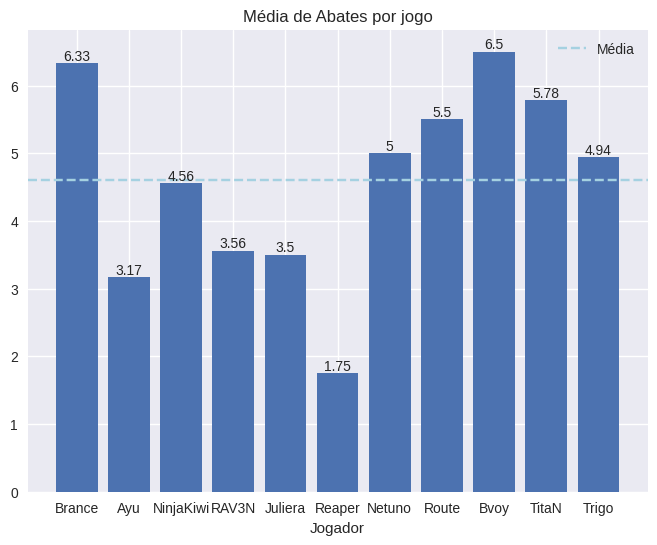

In [715]:
ad_kill = ad_carry['K']

bar_larg = 0.8
size = [8,6]

#canvas
fig, ax = plt.subplots(figsize = size)
bar_plot  = ax.bar(ad_carry.index, ad_kill, bar_larg)

plt.title("Média de Abates por jogo")
plt.xlabel("Jogador")
plt.xticks(np.arange(11), ['Brance', 'Ayu', 'NinjaKiwi', 'RAV3N', 'Juliera', 'Reaper', 'Netuno',
       'Route', 'Bvoy', 'TitaN', 'Trigo'], rotation = 0, )
plt.bar_label(bar_plot)

#média
plt.axhline(np.mean(ad_kill), linestyle='dashed', color = '#a5d1e1')
ax.legend(['Média'])


#label




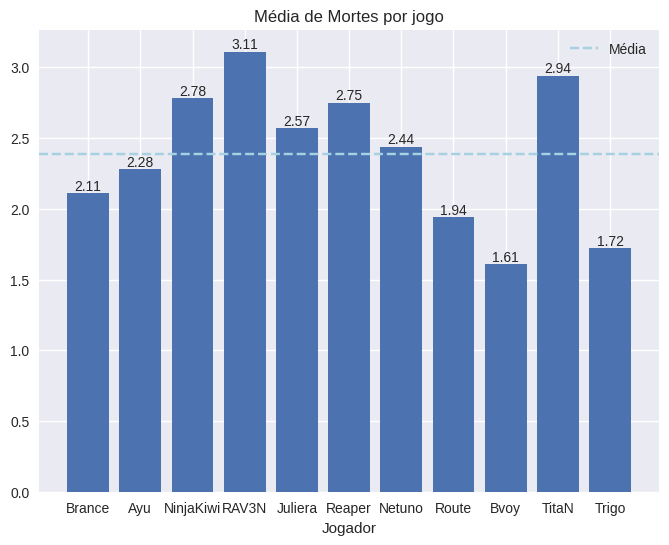

In [716]:
ad_death = ad_carry['D']

bar_larg = 0.8
fig, ax = plt.subplots(figsize = size)
bar_plot  = ax.bar(ad_carry.index, ad_death, bar_larg)

plt.title("Média de Mortes por jogo")
plt.xlabel("Jogador")
plt.xticks(np.arange(11), ['Brance', 'Ayu', 'NinjaKiwi', 'RAV3N', 'Juliera', 'Reaper', 'Netuno',
       'Route', 'Bvoy', 'TitaN', 'Trigo'], rotation = 0, )
plt.bar_label(bar_plot)

#média
plt.axhline(np.mean(ad_death), linestyle='dashed', color = '#a5d1e1')
ax.legend(['Média'])

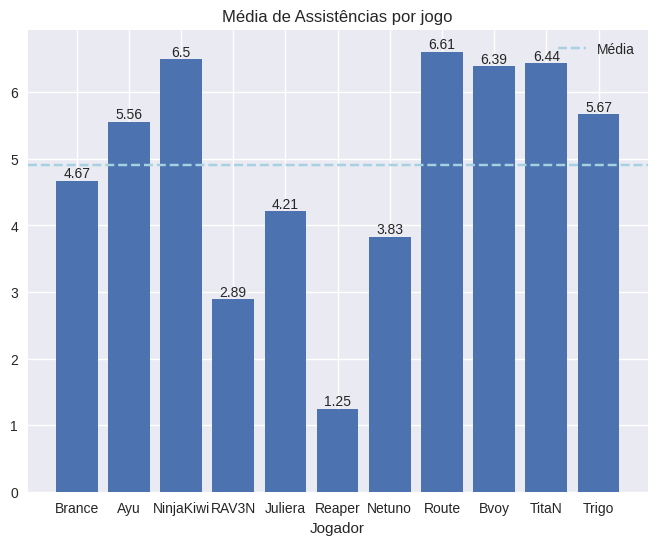

In [717]:
ad_assis = ad_carry['A']

bar_larg = 0.8
fig, ax = plt.subplots(figsize = size)
bar_plot  = ax.bar(ad_carry.index, ad_assis, bar_larg)

plt.title("Média de Assistências por jogo")
plt.xlabel("Jogador")
plt.xticks(np.arange(11), ['Brance', 'Ayu', 'NinjaKiwi', 'RAV3N', 'Juliera', 'Reaper', 'Netuno',
       'Route', 'Bvoy', 'TitaN', 'Trigo'], rotation = 0, )
plt.bar_label(bar_plot)

#média
plt.axhline(np.mean(ad_assis), linestyle='dashed', color = '#a5d1e1')
ax.legend(['Média'])

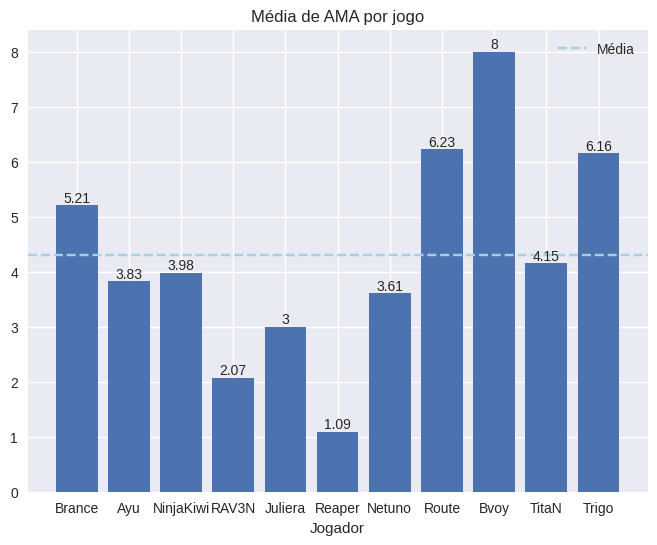

In [718]:
ad_KDA = ad_carry['KDA']

bar_larg = 0.8
fig, ax = plt.subplots(figsize = size)
bar_plot  = ax.bar(ad_carry.index, ad_KDA, bar_larg)

plt.title("Média de AMA por jogo")
plt.xlabel("Jogador")
plt.xticks(np.arange(11), ['Brance', 'Ayu', 'NinjaKiwi', 'RAV3N', 'Juliera', 'Reaper', 'Netuno',
       'Route', 'Bvoy', 'TitaN', 'Trigo'], rotation = 0, )
plt.bar_label(bar_plot)

#média
plt.axhline(np.mean(ad_KDA), linestyle='dashed', color = '#a5d1e1')
ax.legend(['Média'])

**Bvoy, TitaN e Brance** foram os líderes em abates durante o segundo split do cblol.

**Bvoy, Trigo e Route** foram os adcarries com menos mortes por jogo no segundo split do cblol.

**Route, NinjaKiwi e titaN** foram os líderes em assistência dentre os adcarries no segundo split do cblol.

**Bvoy, Route e Trigo** lideraram no quesito AMA (KDA) durante o segundo split do cblol.


**DESTAQUE**: Bvoy liderou em abates e foi o adc com menor número de mortes durante a fase regular do segundo turno, seu AMA é significativamente maior que a média dentre os adcarries.

In [719]:
ad_carry.head()

,Team,Games,W,L,WR,K,D,A,KDA,CS,CS/M,Gold,G/M,DMG,DMG/M,KPAR,KS,GS,CP,mpc,Role
Player,,,,,,,,,,,,,,,,,,,,,
Brance,Fluxo,18,11,7,61.1%,6.33,2.11,4.67,5.21,337.39,9.91,16.10,473.00,29.9k,876.50,78.6%,45.2%,26.1%,7,Kai'Sa,Bot
Ayu,FURIA,18,8,10,44.4%,3.17,2.28,5.56,3.83,320.78,9.38,14.70,430.00,19.9k,581.50,71%,25.8%,24.4%,11,Kai'Sa,Bot
NinjaKiwi,INTZ,18,11,7,61.1%,4.56,2.78,6.50,3.98,318.61,9.62,15.00,454.00,23.5k,710.20,75.1%,30.9%,24.9%,7,Xayah,Bot
RAV3N,KaBuM! Esports,18,1,17,5.6%,3.56,3.11,2.89,2.07,304.56,9.10,13.40,401.00,17k,508.40,69.5%,38.3%,24.5%,9,Kai'Sa,Bot
Juliera,Liberty,14,2,12,14.3%,3.50,2.57,4.21,3.00,319.71,9.52,14.30,425.00,24.4k,728.00,65.1%,29.5%,24.9%,6,Aphelios,Bot


## 1.2 - Farm

Comparação no que diz respeito ao cs e cs/m, ou seja, o farm de cada adcarry.

In [720]:
ad_cs = ad_carry.groupby('Player')[['CS/M','CS']].sum()
ad_cs

,CS/M,CS
Player,,
Ayu,9.38,320.78
Brance,9.91,337.39
Bvoy,9.95,330.39
Juliera,9.52,319.71
Netuno,9.48,304.22
NinjaKiwi,9.62,318.61
RAV3N,9.10,304.56
Reaper,7.98,206.75
Route,9.40,300.67


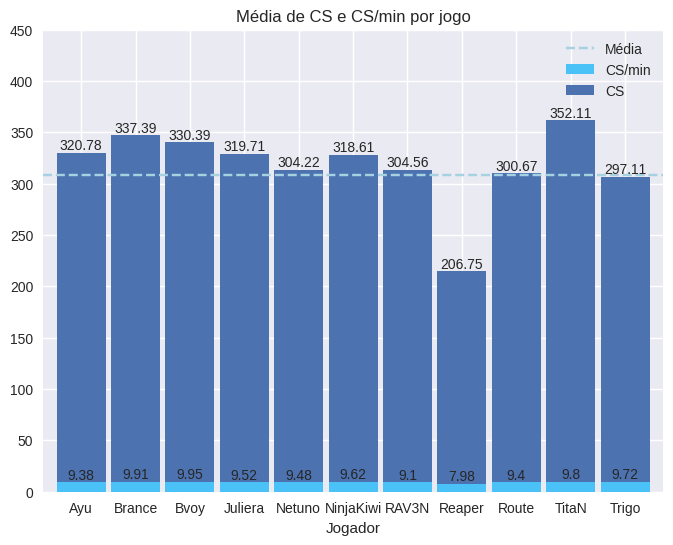

In [746]:

bar_plot = ad_cs.plot(kind = 'bar', stacked = True, figsize = size,
                      width = 0.9, color = [ '#4AC1F7','#4C72B0'])

#config
plt.title('Média de CS e CS/min por jogo')
plt.xlabel('Jogador')
plt.xticks(np.arange(11), rotation = 0)
plt.ylim(0,450)


#bar label
for c in bar_plot.containers:
  label = [v.get_height().round(2) for v in c]
  plt.bar_label(c, labels = label, label_type = 'edge')

#média
plt.axhline(np.mean(ad_carry['CS']), linestyle='dashed', color = '#a5d1e1')
plt.legend(['Média', 'CS/min', 'CS'])

**Observação**: O jogador **Reaper** atuou em apenas 4 jogos, sendo assim é esperado que suas estatísticas sejam bastante diferentes da dos demais com mais jogos.

In [722]:
ad_carry["Gold"] = ad_carry["Gold"]*1000
ad_gold = ad_carry.groupby("Player")[['G/M','Gold']].sum()
ad_gold

,G/M,Gold
Player,,
Ayu,430.00,"14,700.00"
Brance,473.00,"16,100.00"
Bvoy,487.00,"16,200.00"
Juliera,425.00,"14,300.00"
Netuno,452.00,"14,500.00"
NinjaKiwi,454.00,"15,000.00"
RAV3N,401.00,"13,400.00"
Reaper,341.00,"8,800.00"
Route,459.00,"14,700.00"


In [723]:
ad_carry["Gold"]

Player
Brance      16,100.00
Ayu         14,700.00
NinjaKiwi   15,000.00
RAV3N       13,400.00
Juliera     14,300.00
Reaper       8,800.00
Netuno      14,500.00
Route       14,700.00
Bvoy        16,200.00
TitaN       17,000.00
Trigo       14,000.00
Name: Gold, dtype: float64

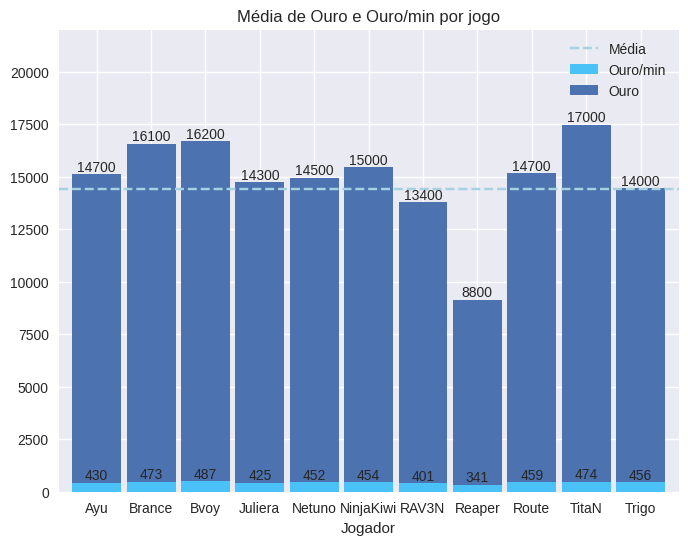

In [748]:
#Gold e Gold/Minuto

bar_plot = ad_gold.plot(kind = 'bar', stacked = True, figsize = size,
                      width = 0.9, color = [ '#4AC1F7','#4C72B0'])

#config
plt.title('Média de Ouro e Ouro/min por jogo')
plt.xlabel('Jogador')
plt.xticks(np.arange(11), rotation = 0)
plt.ylim(0, 22000)


#bar label
for c in bar_plot.containers:
  label = [int(v.get_height()) for v in c]
  plt.bar_label(c, labels = label )

#média
plt.axhline(np.mean(ad_carry["Gold"]), linestyle='dashed', color = '#a5d1e1')
plt.legend(['Média', 'Ouro/min', 'Ouro'])


##1.3 - Participação em Abates e Abates compartilhados

Participação em abates é a porcentagem de participações, abates e assistências, do total de abates do time ((Kill+Assist)/Team kill). Abates compatilhadados é o percentual de abates do total de abates do time relativo a cada jogador(Kill/Team Kill).

Observação: O jogador Reaper atuou em apenas 4 jogos, sendo assim é esperado que suas estatísticas sejam bastante diferentes da dos demais com mais jogos.

In [725]:
ad_carry.head()

,Team,Games,W,L,WR,K,D,A,KDA,CS,CS/M,Gold,G/M,DMG,DMG/M,KPAR,KS,GS,CP,mpc,Role
Player,,,,,,,,,,,,,,,,,,,,,
Brance,Fluxo,18,11,7,61.1%,6.33,2.11,4.67,5.21,337.39,9.91,"16,100.00",473.00,29.9k,876.50,78.6%,45.2%,26.1%,7,Kai'Sa,Bot
Ayu,FURIA,18,8,10,44.4%,3.17,2.28,5.56,3.83,320.78,9.38,"14,700.00",430.00,19.9k,581.50,71%,25.8%,24.4%,11,Kai'Sa,Bot
NinjaKiwi,INTZ,18,11,7,61.1%,4.56,2.78,6.50,3.98,318.61,9.62,"15,000.00",454.00,23.5k,710.20,75.1%,30.9%,24.9%,7,Xayah,Bot
RAV3N,KaBuM! Esports,18,1,17,5.6%,3.56,3.11,2.89,2.07,304.56,9.10,"13,400.00",401.00,17k,508.40,69.5%,38.3%,24.5%,9,Kai'Sa,Bot
Juliera,Liberty,14,2,12,14.3%,3.50,2.57,4.21,3.00,319.71,9.52,"14,300.00",425.00,24.4k,728.00,65.1%,29.5%,24.9%,6,Aphelios,Bot


In [ ]:
kill_par = ad_carry[['KPAR','KS']]

#retirando % dos dados
kpar = []
for i in kill_par['KPAR']:
  i = i.replace("%", "")
  kpar.append(i)

ks = []
for j in kill_par['KS']:
  j = j.replace("%","")
  ks.append(j)

#Atribuindo os valores
kill_par['KPAR'] = kpar
kill_par['KS'] = ks

In [727]:
#mudando para numérico
kill_par = kill_par.astype({'KPAR':float, 'KS':float})

In [728]:
kill_info = kill_par.groupby('Player')[['KS','KPAR']].sum()

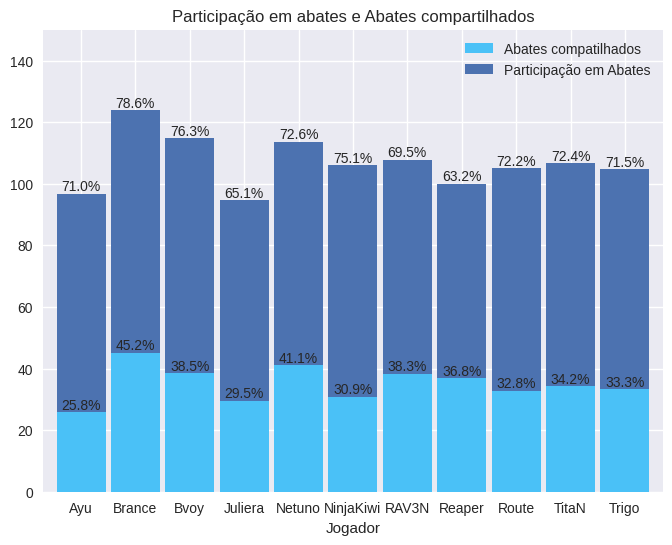

In [743]:
#plot
bar_plot = kill_info.plot(kind = 'bar', stacked = True, figsize = size,
                      width = 0.9, color = ['#4AC1F7','#4C72B0'])

#config
plt.title('Participação em abates e Abates compartilhados')
plt.xlabel('Jogador')
plt.xticks(np.arange(11), rotation = 0)
plt.ylim(0, 150)
plt.legend(['Abates compatilhados', 'Participação em Abates'])

#label
for c in bar_plot.containers:
  label = [str(v.get_height())+'%' for v in c]
  plt.bar_label(c, labels = label)


**Brance, Bvoy e NinjaKiwi** foram os atiradores que mais tiveram participações em abates (Abates+assistências) durante o segundo split do CBLOL. **Brance** foi responsável por aproximadamente 45% do total de abates do seu time durante o segundo split, apenas **Netuno** tem marca similar, representando aproximadamente 41% do total de abates do seu time.

O que pode levar a crer que esses jogadores desempenham papel central ofensivamente em seus respectivos times.

Observação: O jogador Reaper atuou em apenas 4 jogos, sendo assim é esperado que suas estatísticas sejam bastante diferentes da dos demais com mais jogos.

##1.4 - Dano total e dano por minuto médios.

Nessa etapa iremos nos atentar ao **Dano total médio por partida** e **dano por minuto por partida**.

In [730]:
ad_carry.head()

,Team,Games,W,L,WR,K,D,A,KDA,CS,CS/M,Gold,G/M,DMG,DMG/M,KPAR,KS,GS,CP,mpc,Role
Player,,,,,,,,,,,,,,,,,,,,,
Brance,Fluxo,18,11,7,61.1%,6.33,2.11,4.67,5.21,337.39,9.91,"16,100.00",473.00,29.9k,876.50,78.6%,45.2%,26.1%,7,Kai'Sa,Bot
Ayu,FURIA,18,8,10,44.4%,3.17,2.28,5.56,3.83,320.78,9.38,"14,700.00",430.00,19.9k,581.50,71%,25.8%,24.4%,11,Kai'Sa,Bot
NinjaKiwi,INTZ,18,11,7,61.1%,4.56,2.78,6.50,3.98,318.61,9.62,"15,000.00",454.00,23.5k,710.20,75.1%,30.9%,24.9%,7,Xayah,Bot
RAV3N,KaBuM! Esports,18,1,17,5.6%,3.56,3.11,2.89,2.07,304.56,9.10,"13,400.00",401.00,17k,508.40,69.5%,38.3%,24.5%,9,Kai'Sa,Bot
Juliera,Liberty,14,2,12,14.3%,3.50,2.57,4.21,3.00,319.71,9.52,"14,300.00",425.00,24.4k,728.00,65.1%,29.5%,24.9%,6,Aphelios,Bot


In [731]:
dmg_ad = ad_carry[['DMG','DMG/M']] #cópia dos dados para análise separada

In [732]:
dmg_ad

#limpeza
dmg_new = []
for i in dmg_ad['DMG']:
  i = float(i.replace('k', ''))*1000
  dmg_new.append(i)

dmg_ad['DMG'] = dmg_new

# #datatype
# dmg_ad = dmg_ad.astype({'DMG': float})

<ipython-input-732-0c8270d492bf>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dmg_ad['DMG'] = dmg_new


**Observação**: k representa 1000, ajustei isso na limpeza e conversão anterior para construção adequada do gráfico.

In [733]:
#verificando
dmg_ad_info = dmg_ad.groupby('Player')[['DMG/M','DMG']].sum()
dmg_ad_info

,DMG/M,DMG
Player,,
Ayu,581.50,"19,900.00"
Brance,876.50,"29,900.00"
Bvoy,803.20,"26,700.00"
Juliera,728.00,"24,400.00"
Netuno,720.00,"23,100.00"
NinjaKiwi,710.20,"23,500.00"
RAV3N,508.40,"17,000.00"
Reaper,489.20,"12,700.00"
Route,727.80,"23,300.00"


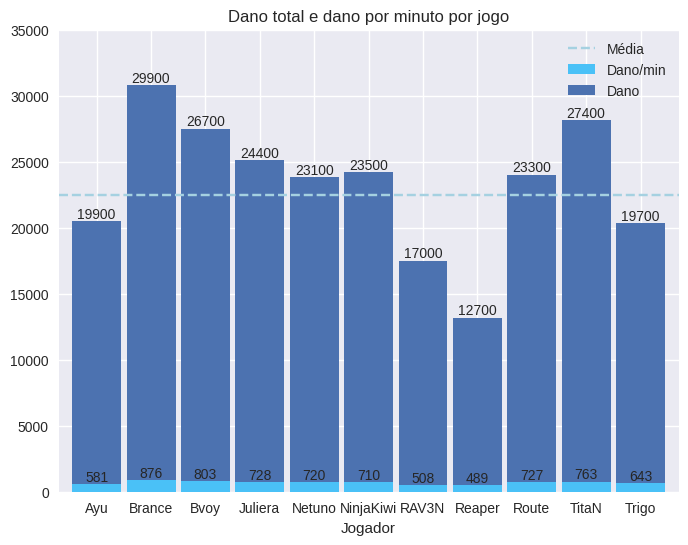

In [744]:
bar_plot = dmg_ad_info.plot(kind = 'bar',stacked = True, figsize = size,
                      width = 0.9, color = ['#4AC1F7','#4C72B0'])

#config
plt.title('Dano total e dano por minuto por jogo')
plt.xlabel('Jogador')
plt.xticks(np.arange(11), rotation = 0)
plt.ylim(0, 35000)

#label
for c in bar_plot.containers:
  label = [int(v.get_height()) for v in c]
  plt.bar_label(c, labels = label)

#Média
plt.axhline(np.mean(dmg_ad["DMG"]), linestyle='dashed', color = '#a5d1e1')
plt.legend(['Média', 'Dano/min', 'Dano'])

**Brance, Bvoy e Titan** aparecem como destaques da fase regular do segundo split do CBLOL no que diz respeito a dano total por partida.

##1.5 - Gold share/Ouro compartilhado

Porcentagem de ouro que o jogador possui do total de ouro do seu time.


In [735]:
#varíavel para análise
gs = ad_carry["GS"]

In [736]:
gs

Player
Brance       26.1%
Ayu          24.4%
NinjaKiwi    24.9%
RAV3N        24.5%
Juliera      24.9%
Reaper       22.6%
Netuno       25.8%
Route        24.6%
Bvoy         25.6%
TitaN        25.3%
Trigo        24.8%
Name: GS, dtype: object

In [737]:
gs_new = []

for i in gs:
  i = float(i.replace('%', ''))
  gs_new.append(i)

gs = pd.Series(gs_new, index=gs.index)

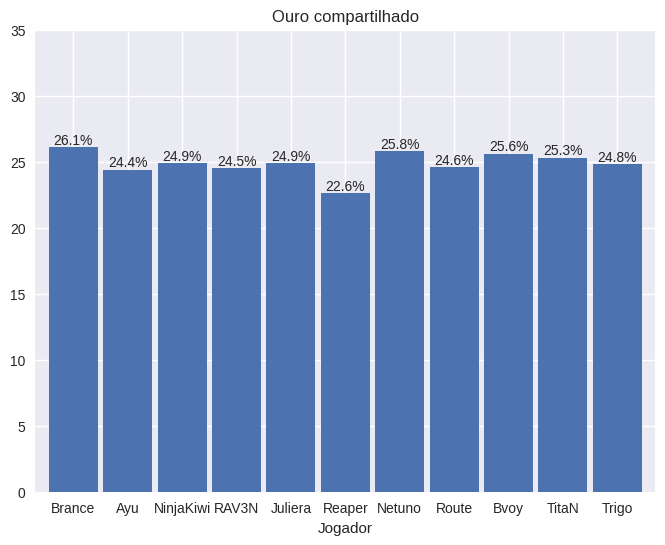

In [741]:
bar_plot = gs.plot(kind = 'bar', figsize = size,
                      width = 0.9, color = ['#4C72B0'])

#config
plt.title('Ouro compartilhado')
plt.xlabel('Jogador')
plt.xticks(np.arange(11), rotation = 0)
plt.ylim(0, 35)
plt.legend()

#label
for c in bar_plot.containers:
  label = [str(v.get_height())+'%' for v in c]
  plt.bar_label(c, labels = label)

**Brance** aparece com maior percentual de ouro compartilhado, ou seja, foi o atirador com maior porcentagem de ouro do ouro total de seu time. Aparentemente recebeu maior parte dos recursos nas partidas do seu time. Os jogadores que se destacaram nesse quesito foram **Brance, Netuno e Bvoy**.

##1.1 - Suportes

Comparativos das estatísticas dos suportes do segundo split do CBLOL.

In [750]:
df_cblol.head()

,Team,Player,Games,W,L,WR,K,D,A,KDA,CS,CS/M,Gold,G/M,DMG,DMG/M,KPAR,KS,GS,CP,mpc,Role
0,Fluxo,Brance,18,11,7,61.1%,6.33,2.11,4.67,5.21,337.39,9.91,16.10,473.00,29.9k,876.50,78.6%,45.2%,26.1%,7,Kai'Sa,Bot
1,Fluxo,Disamis,18,11,7,61.1%,2.22,2.11,7.94,4.82,174.67,5.13,11.20,329.00,11.4k,335.50,72.6%,15.9%,18.2%,9,Maokai,Jungle
2,Fluxo,hauz,18,11,7,61.1%,3.06,2.78,6.06,3.28,282.78,8.30,13.70,402.00,22.4k,658.50,65.1%,21.8%,22.2%,7,Ahri,Mid
3,Fluxo,JoJo,18,11,7,61.1%,0.39,2.61,10.83,4.30,38.39,1.13,8.10,237.00,5.2k,153.70,80.2%,2.8%,13.1%,6,Rakan,Sup
4,Fluxo,Tay,18,11,7,61.1%,2.00,1.89,6.11,4.29,253.94,7.46,12.60,370.00,12.8k,374.50,57.9%,14.3%,20.4%,8,K'Sante,Top


In [751]:
sup = df_cblol.loc[df_cblol['Role'] == 'Sup'].set_index('Player')
sup

,Team,Games,W,L,WR,K,D,A,KDA,CS,CS/M,Gold,G/M,DMG,DMG/M,KPAR,KS,GS,CP,mpc,Role
Player,,,,,,,,,,,,,,,,,,,,,
JoJo,Fluxo,18,11,7,61.1%,0.39,2.61,10.83,4.30,38.39,1.13,8.10,237.00,5.2k,153.70,80.2%,2.8%,13.1%,6,Rakan,Sup
zay,FURIA,18,8,10,44.4%,1.50,2.44,8.11,3.93,34.00,0.99,8.20,239.00,5.7k,167.30,78.3%,12.2%,13.5%,10,Pyke,Sup
Nia,INTZ,18,11,7,61.1%,0.39,3.00,12.17,4.19,37.28,1.13,8.00,242.00,4.2k,126.80,85.3%,2.6%,13.3%,5,Rell,Sup
RedBert,KaBuM! Esports,18,1,17,5.6%,0.61,4.61,5.89,1.41,34.78,1.04,7.10,211.00,4.5k,134.00,70.1%,6.6%,12.9%,9,Rakan,Sup
Wos,Liberty,13,2,11,15.4%,0.38,3.85,8.46,2.30,23.85,0.70,7.40,217.00,5.5k,161.90,72.3%,3.1%,12.6%,8,Rakan,Sup
Cavalo,Liberty,4,0,4,0%,0.25,2.75,3.75,1.45,32.25,1.25,5.50,212.00,3.2k,122.60,84.2%,5.3%,14%,4,Rell,Sup
Momochi,Liberty,1,0,1,0%,1.00,6.00,1.00,0.33,24.00,0.92,5.70,220.00,3.1k,118.90,28.6%,14.3%,14.2%,1,Alistar,Sup
Ranger,Los Grandes,18,6,12,33.3%,0.61,4.06,8.33,2.21,33.28,1.04,7.50,234.00,4.3k,135.50,73.5%,5%,13.4%,10,Rell,Sup
Ceos,LOUD,18,13,5,72.2%,0.83,2.28,12.83,6.00,35.56,1.11,8.00,251.00,4.4k,136.70,81.5%,5%,13.4%,7,Rakan,Sup
